In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import functions as fn
import Box
import Halo
import myRCParams

In [2]:
z = 2
xBins = np.logspace(-2, 0, 21)
mBins = np.logspace(10.5, 13.2, 11)
k = np.logspace(-1, 2, 30)
is_normalize = True

In [3]:
x = np.sqrt(xBins[:-1]*xBins[1:])
m = np.sqrt(mBins[:-1]*mBins[1:])
logm = np.log10(m)

In [4]:
box = Box.Box(fn.box_path, fn.shot[z])
mass_ref = 1

In [5]:
def get_mod_power(model, z, mass_ref):
    df = pd.read_csv(fn.here_path/'Density_Profiles'/f'box_z{z}.csv')
    halo_mass = np.array(df.iloc[:,1])
    halo_density = np.array(df.iloc[:, 2:-1]) * 1e9
    halo_r200c = np.array(df.iloc[:,-1]) * 1e-3
    pos = np.array([0,0,0])

    box_halos = [Halo.Halo(pos, r200c) for r200c in halo_r200c]

    for i, halo in enumerate(box_halos):
        halo.mass = halo_mass[i]
        halo.density = halo_density[i,:]

    avg_halos, no_halos = fn.get_mass_avg_density(box_halos, xBins, mBins)
    
    df = pd.read_csv(fn.here_path/'Density_Profiles'/f'{model}_z{z}.csv')
    mod_mass = np.array(df.iloc[:,1])
    mod_density = np.array(df.iloc[:, 2:-1])
    mod_r200c = np.array(df.iloc[:,-1])   
    mod_halo = Halo.Halo(pos, mod_r200c)
    mod_halo.mass = mod_mass
    mod_halo.density = mod_density[0,:]

    if is_normalize:
        if model == 'REF':
            mass_ref = mod_halo.mass
        else:
            mod_halo.density *= mass_ref/mod_halo.mass
            mod_halo.mass = mass_ref

    ndx = np.where((mod_halo.mass*1e10>=mBins[:-1])&(mod_halo.mass*1e10<mBins[1:]))[0]
    
    avg_halos[ndx] = mod_halo
    fg, ax = plt.subplots()
    ax.loglog()
    ax.set_xlabel(r'$r/r_{200}$')
    ax.set_ylabel(r'$\langle\rho_\mathrm{total}\rangle(r)[(\mathrm{Mpc}/h)^3]$')
    for i, halo in enumerate(avg_halos):
        ax.plot(x, halo.density, linewidth=3, label=round(logm[i],2))
    ax.legend(title='$\log(M_\mathrm{bin}/(\mathrm{M}_\odot/h))$')
    ax.set_title = model
    
    [halo.get_u(x, k) for halo in avg_halos]
    #print([halo.u.shape for halo in avg_halos])
    fg2, ax2 = plt.subplots()
    ax2.loglog()
    ax2.set_xlabel(r'$k[(\mathrm{Mpc}/h)^{-1}]$')
    ax2.set_ylabel(r'$u(k|M)$')
    for i, halo in enumerate(avg_halos):
        ax2.plot(k, halo.u, linewidth=3, label=round(logm[i],2))
    ax2.legend(title='$\log(M_\mathrm{bin}/(\mathrm{M}_\odot/h))$')
    ax2.set_title = model
    
    P_1h = fn.get_power(box, avg_halos, k, mBins, z, no_halos)
    
    fg3, ax3 = plt.subplots()
    ax3.loglog()
    ax3.set_xlabel(r'$k[(\mathrm{Mpc}/h)^{-1}]$')
    ax3.set_ylabel(r'$P_\mathrm{1h}[(\mathrm{Mpc}/h)^3]$')
    ax3.plot(k, P_1h, linewidth=3)
    ax3.set_title = model
    
    if is_normalize:
        file_name = 'norm'
    else:
        file_name = 'unnorm'
        
    with open(fn.here_path/'Power_Spectra'/f'{model}_{file_name}_z{z}.csv', 'w') as f:
        header = 'k, P_1h \n'
        f.write(header)
        np.savetxt(f, np.c_[k, P_1h], delimiter=',')
    
    return mass_ref

/data/ERCblackholes4/eac83/FABLE_S8/functions.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  hist = np.array(np.histogram(mass, bins=m))
/data/ERCblackholes4/eac83/FABLE_S8/functions.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  hist = np.array(np.histogram(mass, bins=m))
/data/ERCblackholes4/eac83/FABLE_S8/functions.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

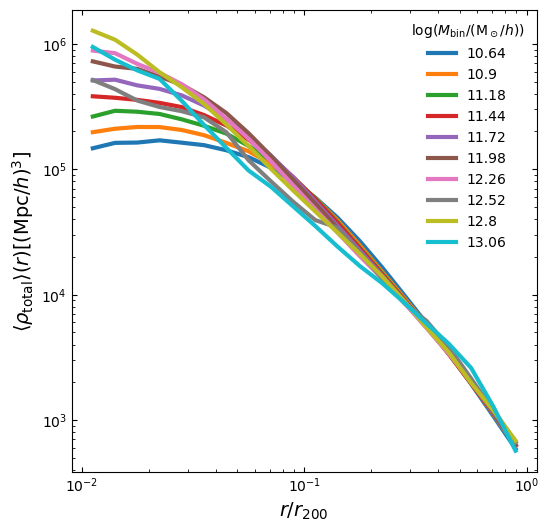

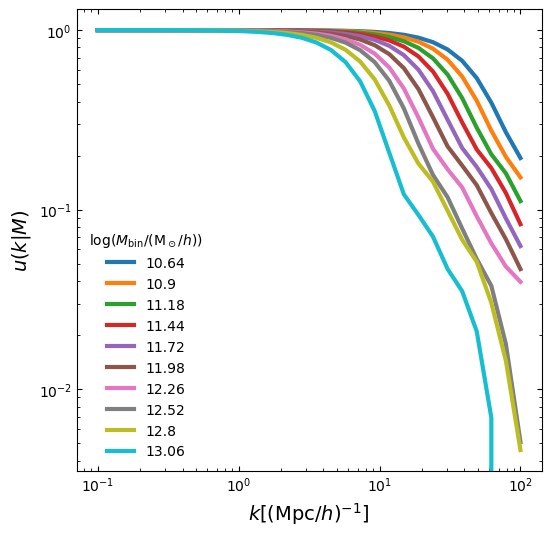

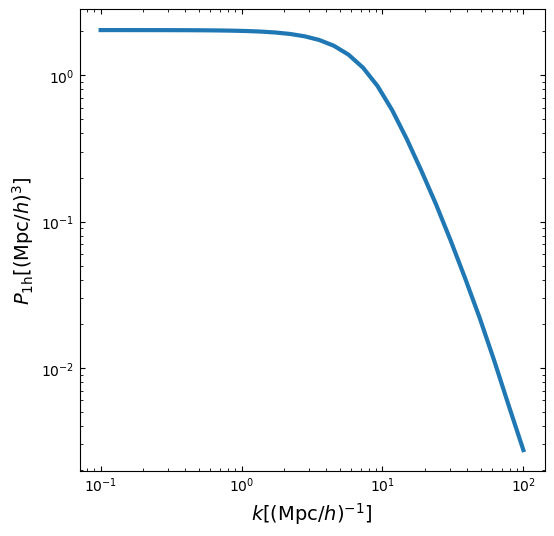

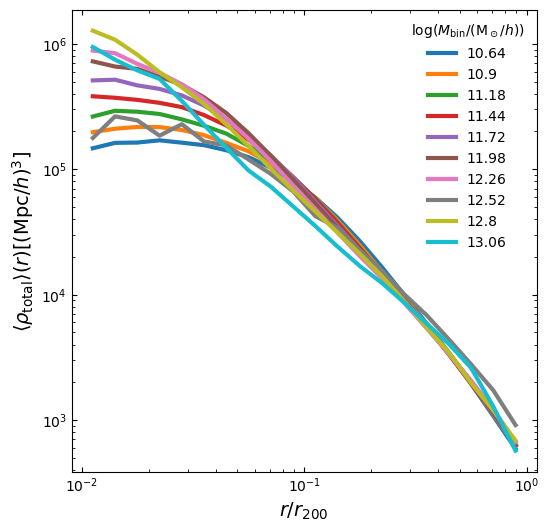

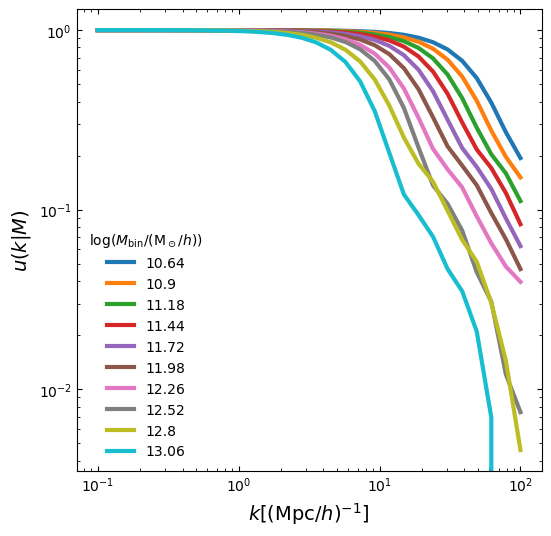

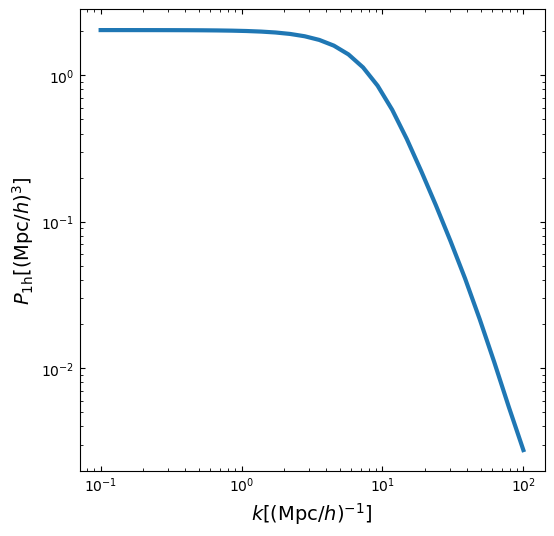

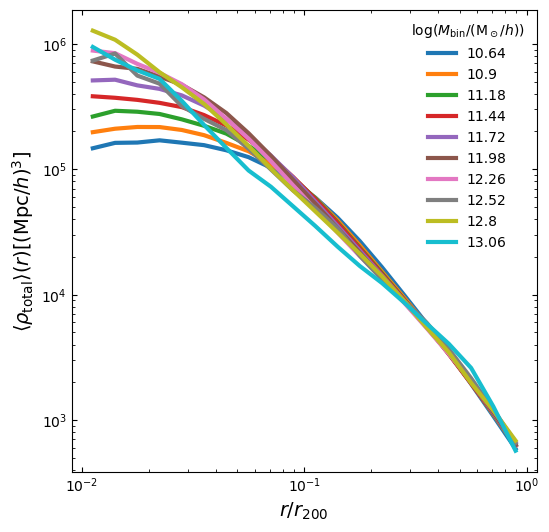

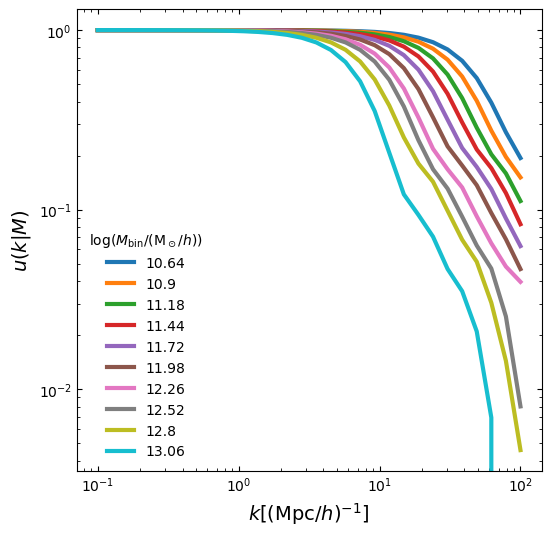

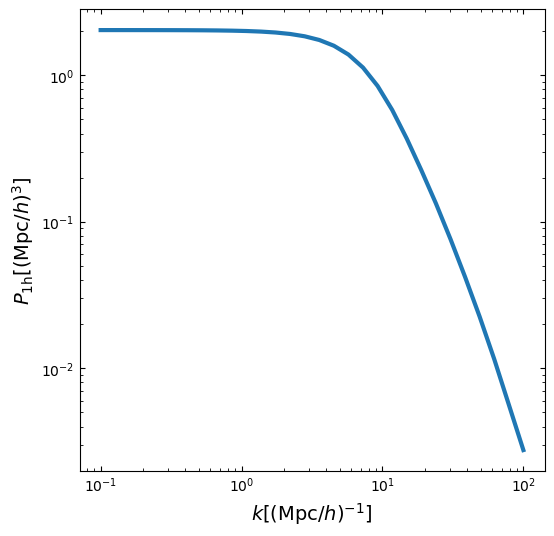

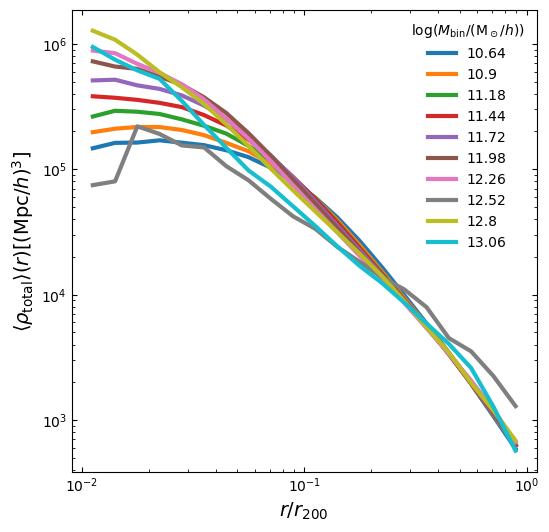

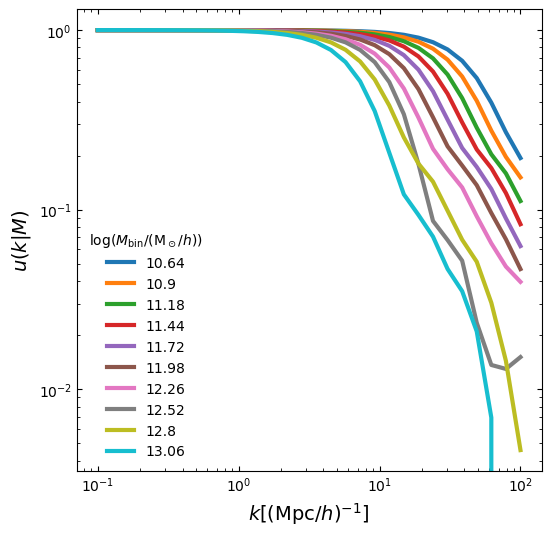

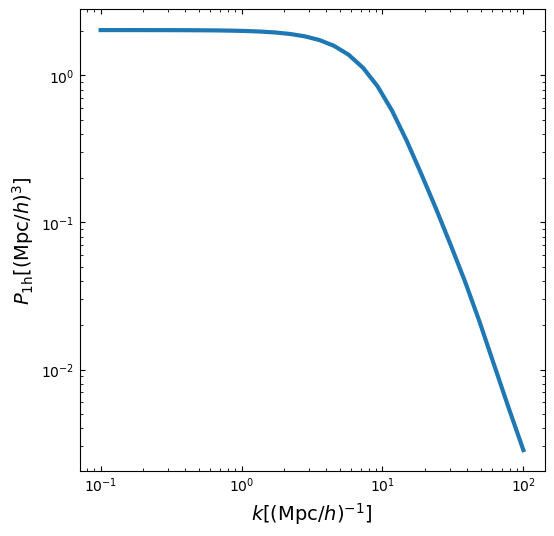

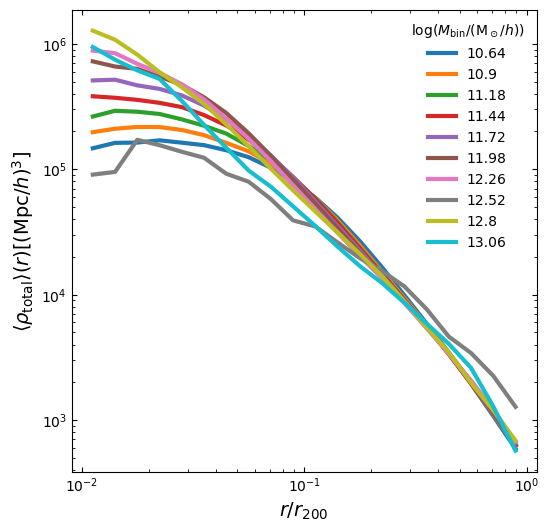

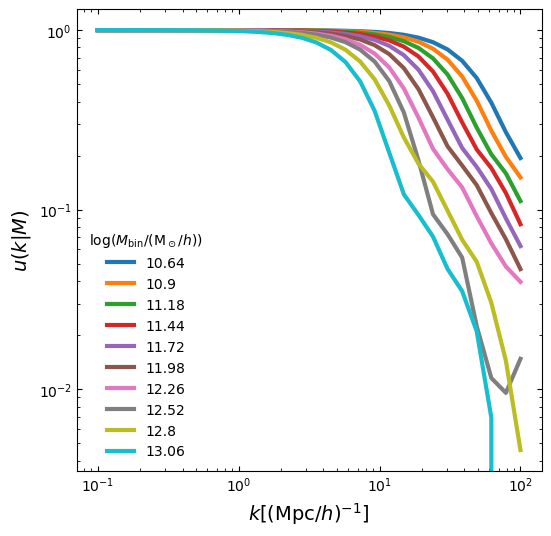

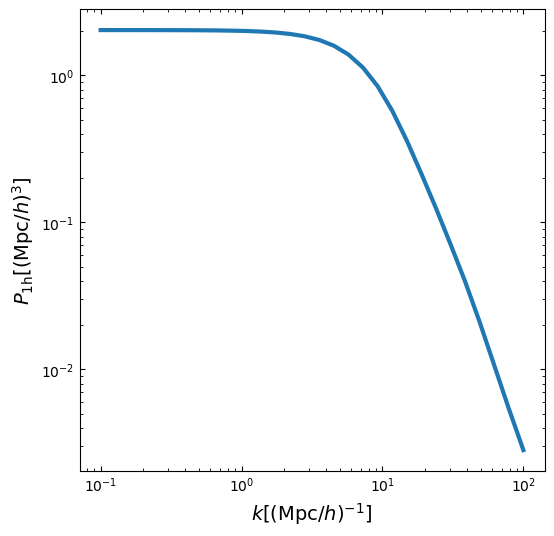

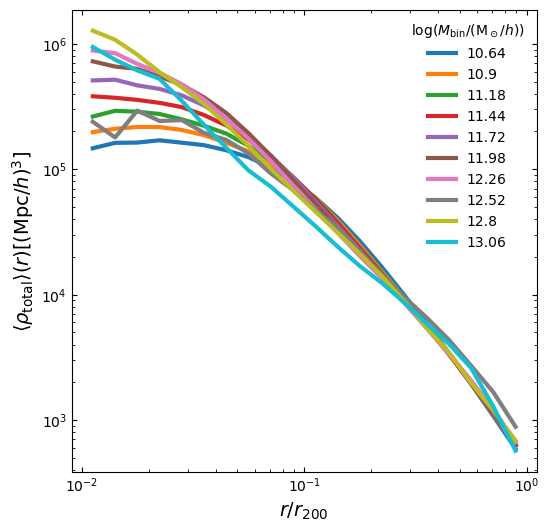

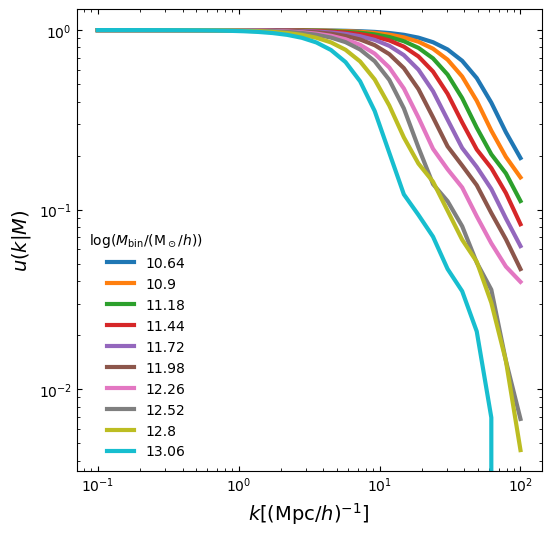

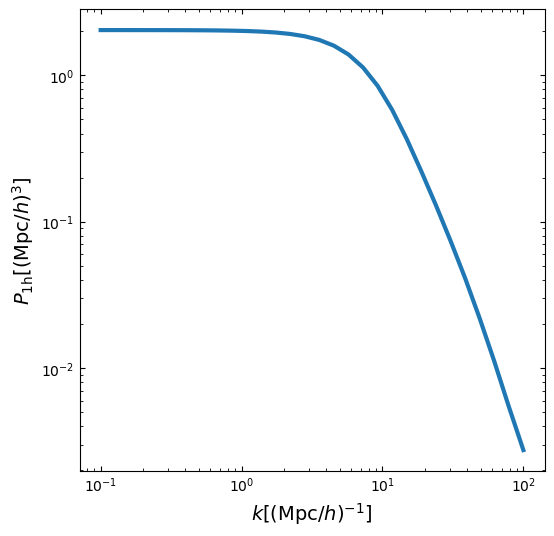

In [6]:
for model in fn.models:
    mass_ref = get_mod_power(model, z, mass_ref)